## EDSA Traffic Data Analysis and Visualization: Analysis

#### Pre-processing ####

After an extraction period of 7 days, sufficient data has been collected in order to start munging. Pre-processing will be executed in the following manner:
1. Collate data from raw .csv files
2. Separate aforementioned data into two 2-dimensional numpy arrays (southbound and northbound)
3. Place data in such a way that it is arranged chronologically with respect to the individual lines
4. Take the average for every 4 entries since this represents 1 hour. 

The last step is necessary since visualization and line fitting is unhelpful when considering the entire scope of raw data. Breaking the data into several pieces and analysing each set is more conducive for meaningful story telling. As was explained in the previous notebook, polynomial regression is the tool of choice for this task. 

Note that during the current 7-day timeframe data extraction, there was a holiday in the middle of the week. To be more specific, it fell on a Wednesday. This factor will be taken into consideration when analyzing individual days. 

#### Analysis ####

Polynomial regression with degrees 2 up to 8 will be examined. In particular, the RMS and $R^2$ scores will be taken into consideration when trying to determine if the model is a good fit or not. 

*Validation*:
1. The first method of validation included averaging the likely traffic volume per hour across 6 days and testing the corresponding model on unseen data. 
        The results for this were pretty bad, so a different approach had to be taken.
2. Something something 

# Use this to analyze extracted data!
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statistics 

# For Data parsing
import os
import re

# Use these to test regression scores
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

# set global variables
global runs
global numlines
global slashed_runs
global list_size
global days
global daylist_size
global timeframe # in days

timeframe = 7
runs = 672 
numlines = 37
slashed_runs = int(runs/4)
days = int(slashed_runs/24)
list_size = numlines * runs
daylist_size = int(days * 24 * numlines)


### Pre-processing the data
Before starting analysis, the data has to be extracted from the .csv files and placed neatly in numpy arrays. Numpy arrays are ideal for this situation since they offer a high degree of flexibility and a plethora of capabilities which will greatly slash the time and effort it will take to process data. 

The general flow for pre-processing is as follows:
1. initialize 2 two-dimensional numpy arrays that are meant to contain data for southbound and northbound respectively. 
2. Collect relevant data for each line in EDSA. In total, there are 37 lines. Since data was extracted over a 7 day period every 15 minutes, there should be 672 total data points for each line (7 days x 24 hours x 15 minutes). So, one numpy array has a size of 37 x 672 = 24864. However, these are flexible values. One need only change the value of the runs and numlines variable. 

In [2]:
# save all data in numpy arrays
directory = "/Users/kianavillaera/MMDA_Traffic_data/EDSA-Traffic-Analysis-and-Visualization/April29_to_May6"
j = 0 # file number 

list_of_southbound = np.zeros(list_size).reshape(numlines,runs) 
list_of_northbound = np.zeros(list_size).reshape(numlines,runs)

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        f = open(filename)
        f_list = f.readlines()
        i = 0
        for row in f_list:
            if len(row) == 41:
                vol = re.findall("\d",row)
                list_of_southbound[i][j] = vol[0]
                list_of_northbound[i][j] = vol[1]
                i += 1       
        j +=1 
f.close() 

Note that the only possible values for each data point are 0 (light), 1 (medium), and 2 (heavy). In order to generate closer values, the average over each hour is taken. That is, every 4 entries is averaged to create a new data point. 

Numpy achieves this beautifully and succintly with its built-in function "mean". 

#### Fatal error (resolved): Forgot to consider that there are 37 lines. Hence, only took the data for 1 line.

In [3]:
# Pre-process the data (take mean of every 4 entries)
# These numpy arrays will contain the new weighted volumes per hour for each line
data_southbound = np.zeros(numlines * slashed_runs).reshape(numlines, slashed_runs)
data_northbound = np.zeros(numlines * slashed_runs).reshape(numlines, slashed_runs)

for i in range(0,numlines):
    data_southbound[i][0:slashed_runs] = np.mean(list_of_southbound[i].reshape(-1, 4), axis=1)
    data_northbound[i][0:slashed_runs] = np.mean(list_of_northbound[i].reshape(-1, 4), axis = 1)  
    # For cross validation!
    print(data_northbound[i][0:slashed_runs])
    print(list_of_northbound[i][0:runs])

[0.25 0.75 0.25 0.   0.5  0.   0.5  0.25 0.25 0.5  1.5  0.75 0.75 0.75
 0.   0.25 1.   0.75 1.   0.75 0.25 0.   0.   0.25 0.25 0.75 0.25 1.
 0.75 1.25 0.   0.   0.5  0.25 0.5  0.5  0.5  0.75 0.5  0.5  0.5  0.25
 0.75 0.5  0.5  0.5  0.5  0.5  0.5  0.25 0.75 0.5  0.25 1.25 0.5  0.75
 1.5  0.   0.   0.5  0.5  0.25 0.5  1.   1.25 0.5  0.   0.5  0.5  1.25
 0.5  0.25 0.25 0.5  0.25 0.75 0.75 0.25 0.75 1.5  1.   0.75 0.25 0.25
 0.75 0.5  0.25 0.25 0.5  0.25 0.5  1.   0.75 0.5  0.5  1.25 0.5  0.
 0.5  0.5  0.5  0.   1.   0.75 0.5  0.5  0.25 0.5  0.25 1.25 0.   0.5
 0.25 1.   0.5  0.25 1.   0.25 0.25 0.75 0.75 1.   0.5  0.75 0.   0.75
 1.   0.5  1.   0.75 0.75 0.5  0.25 1.   0.25 0.25 0.25 0.75 0.   1.
 0.   0.5  0.5  0.25 0.25 0.75 0.5  0.25 0.75 0.5  0.75 0.5  0.25 0.5
 0.   0.5  1.   0.5  0.75 1.   0.5  1.25 1.   1.   0.25 0.   0.   1.25]
[0. 0. 1. 0. 2. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 2. 1. 2. 1. 0. 2. 0.
 1. 0. 2.

### Analysis strategy
The analyze function takes the numpy array, number of runs, and bound indicator (string) as parameters and outputs a figure containing the datapoints and regression lines. For the polynomial regression, 3 orders (1, 2, and 3) are taken into account. 

The analysis strategy is very simple. However, if good results are attainable, then the tool will be a powerful mathematical model that describes the data trend.

In [4]:
def analyze(data, points, description):
    %matplotlib inline
    x = range(0,points)
    x = np.array(x)
    rms = []
    r2 = []
    
    p2 = np.polyfit(x,data,2)
    p3 = np.polyfit(x,data,3)
    p4= np.polyfit(x, data,4)
    p5 = np.polyfit(x,data,5)
    p6 = np.polyfit(x,data,6)
    p7 = np.polyfit(x,data,7)
    p8 = np.polyfit(x,data,8)
    p9 = np.polyfit(x,data,9)
    
    pred2 = np.polyval(p2,x)
    pred3 = np.polyval(p3,x)
    pred4 = np.polyval(p4,x)
    pred5 = np.polyval(p5,x)
    pred6 = np.polyval(p6,x)
    pred7 = np.polyval(p7,x)
    pred8 = np.polyval(p8,x)
    pred9 = np.polyval(p9,x)
    
    rms.append(sqrt(mean_squared_error(data, pred2)))
    r2.append(r2_score(data, pred2))  
    rms.append(sqrt(mean_squared_error(data, pred3)))
    r2.append(r2_score(data, pred3))  
    rms.append(sqrt(mean_squared_error(data, pred4)))
    r2.append(r2_score(data, pred4)) 
    rms.append(sqrt(mean_squared_error(data, pred5)))
    r2.append(r2_score(data, pred5)) 
    rms.append(sqrt(mean_squared_error(data, pred6)))
    r2.append(r2_score(data, pred6))  
    rms.append(sqrt(mean_squared_error(data, pred7)))
    r2.append(r2_score(data, pred7))  
    rms.append(sqrt(mean_squared_error(data, pred8)))
    r2.append(r2_score(data, pred8))  
    rms.append(sqrt(mean_squared_error(data, pred9)))
    r2.append(r2_score(data, pred9))  
        
    
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(10,10))
    f.suptitle("Polynomial regression of "+ description)
    # add a big axis, hide frame
    f.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Hours in Military Time")
    plt.ylabel("Average Traffic Volume")
    ax1.plot(x,data,'o')
    ax1.plot(x,pred2,'r-')
    ax2.plot(x,data,'o')
    ax2.plot(x,pred3,'b-')
    ax3.plot(x,data,'o')
    ax3.plot(x,pred4,'g-')
    ax4.plot(x,data,'o')
    ax4.plot(x,pred5,'m-')
    ax5.plot(x,data,'o')
    ax5.plot(x,pred6,'k-')
    ax6.plot(x,data,'o')
    ax6.plot(x,pred7,'y-')
    ax7.plot(x,data,'o')
    ax7.plot(x,pred8,'c-')
    ax8.plot(x,data,'o')
    ax8.plot(x,pred9,'r-')

    plt.savefig("Polynomial regression of "+ description + ".png")
    plt.show()
    
    return rms[6], r2[6], pred8

### Initial test for the analysis function
This takes the southbound data of the Balintawak line just to assess initial trends.

The below figure is quite messy. However, this will be kept for documentation purposes since there is a lot to be inferred from the initial visualization results. 
#### Interesting inferences:
    1. It seems that each day must be analyzed individually since taken as a whole, the data does not tell a cohesive story. More than that, the regression lines are horrible fits if all the data is considered (see: outliers). Hence, the need for individual analysis. 
    2. Additionally, though not presented in the figures, the need to average the volume per hour contributes to lessening data points and potentially generating more meaningful data. The raw data on its own is not fit for analysis.

In [5]:
#Analyze something something

### Dividing data into individual days
At this point the data is readily available in numpy arrays. It is wise to further pre-process the data and divide them by sets of 24 points (since 1 day has 24 hours and 1 data point represents 1 hour). This can be achieved with a simple function that loops through the existing numpy arrays and places the appropriate values in new 3-dimensional numpy arrays. 
* Dimension 1: lines, 37 total
* Dimension 2: days, 7 total
* Dimension 3: data points, 24 total

Total entries: 6216 (lines x days x data)

In [6]:
daylists_south = np.zeros(daylist_size).reshape(numlines,timeframe,24)
daylists_north = np.zeros(daylist_size).reshape(numlines,timeframe,24)

def return_daylists(data): # Function that divides days accordingly
    temp = np.zeros(slashed_runs).reshape(timeframe,24) 
    i=0
    for j in range(0,len(data)+1):
        if(j % 24 == 0 and j != 0):
            temp[i][0:24] = data[j-24:j]
            i+=1
    return temp 

for n in range(numlines):
    daylists_south[n][0:timeframe][0:24] = return_daylists(data_southbound[n][0:slashed_runs])
    daylists_north[n][0:timeframe][0:24] = return_daylists(data_northbound[n][0:slashed_runs])
    
# For cross validation
print("Shape is given by: ", daylists_north.shape)
print("Data, first day NORTHBOUND Balintawak: ", data_northbound[0][0:24])
print("Cross check with new numpy array: ", daylists_north[0][0])
print("Data, 2nd day SOUTHBOUND Pioneer-Boni: ", data_southbound[22][24:48])
print("Cross check with new numpy array: ", daylists_south[22][1])

# Cross check last day. 
print("Daylist, 7th day Northbound Pioneer-Boni:", daylists_north[22][6])

Shape is given by:  (37, 7, 24)
Data, first day NORTHBOUND Balintawak:  [0.25 0.75 0.25 0.   0.5  0.   0.5  0.25 0.25 0.5  1.5  0.75 0.75 0.75
 0.   0.25 1.   0.75 1.   0.75 0.25 0.   0.   0.25]
Cross check with new numpy array:  [0.25 0.75 0.25 0.   0.5  0.   0.5  0.25 0.25 0.5  1.5  0.75 0.75 0.75
 0.   0.25 1.   0.75 1.   0.75 0.25 0.   0.   0.25]
Data, 2nd day SOUTHBOUND Pioneer-Boni:  [0.75 0.75 0.75 0.75 0.25 1.75 1.25 0.75 0.25 0.5  1.75 0.5  0.25 0.5
 0.75 0.75 0.5  0.5  0.25 0.25 0.25 0.5  1.   1.  ]
Cross check with new numpy array:  [0.75 0.75 0.75 0.75 0.25 1.75 1.25 0.75 0.25 0.5  1.75 0.5  0.25 0.5
 0.75 0.75 0.5  0.5  0.25 0.25 0.25 0.5  1.   1.  ]
Daylist, 7th day Northbound Pioneer-Boni: [1.   1.5  1.   1.5  1.   1.   1.25 0.75 0.75 1.5  0.5  0.75 0.5  0.5
 1.5  1.5  2.   0.75 1.25 0.75 0.75 0.75 0.5  1.5 ]


### Important Detail: Data Extraction started on 5PM April 29 (MONDAY)
This implies that the data points are relative. That is, if each hour is represented by the list [0 1. . . 23] , then 0 represents 5PM and 23 represents 4PM. 12 represents 5 AM. Etc.

Fix this by rearranging the lists.

Also, can easily collate training data from here. There is no longer a need to do further pre-processing. Hence, training and test data will also be collected.

In [7]:
def fix_time_points(data): # puts data points where they should be. AM/PM
    temp_AM = np.zeros(numlines * timeframe * 12).reshape(numlines,timeframe,12)
    temp_PM = np.zeros(numlines * timeframe * 12).reshape(numlines,timeframe,12)
    temp = np.zeros(daylist_size).reshape(numlines,timeframe,24)
    for i in range(0,37):
        for j in range(0,7):
            temp_AM[i][j] = data[i][j][7:19]
            temp_PM[i][j] = np.concatenate((data[i][j][19:24], data[i][j][0:7])) 
            temp[i][j] = np.concatenate((temp_AM[i][j],temp_PM[i][j]))
    return temp

daylists_north = fix_time_points(daylists_north)
daylists_south = fix_time_points(daylists_south)

### Short test
Before we proceed with automating and cleaning the process of analyzing each day, let us take a sneak peek of the results that we may expect. The four subgraphs contained within the main graph represent the regression lines of order 1 to 4 for the northbound lane for Pioneer-Boni on May 1. 

As is easily observable with lower orders, the regression lines still do not seem like good fits. 

Let's see what happens when we scale up the orders. Use built-in functions to find the Root Mean Square and R^2 score to determine if the regression is good. We can add the F test later. In the case of RMSE, lower is better.

The higher the order, the better the RMS and R2 scores. However, we must be mindful of the possibility of overfitting.

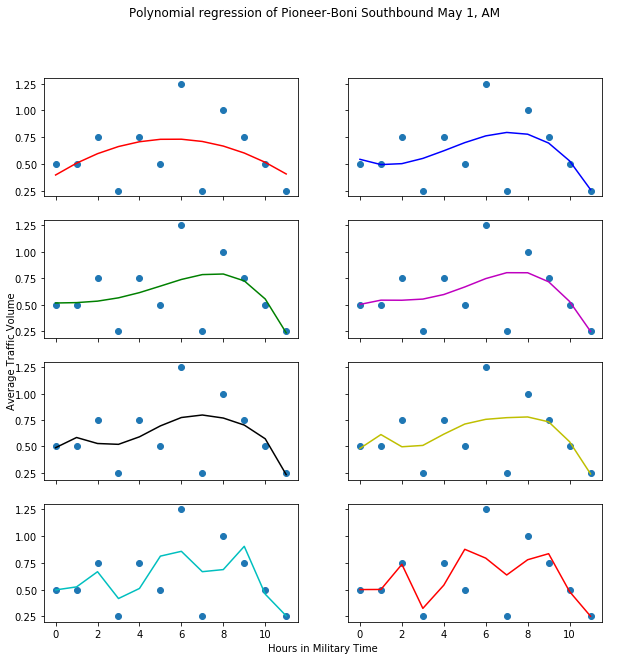

0.23134834171680807
0.3925378560806426


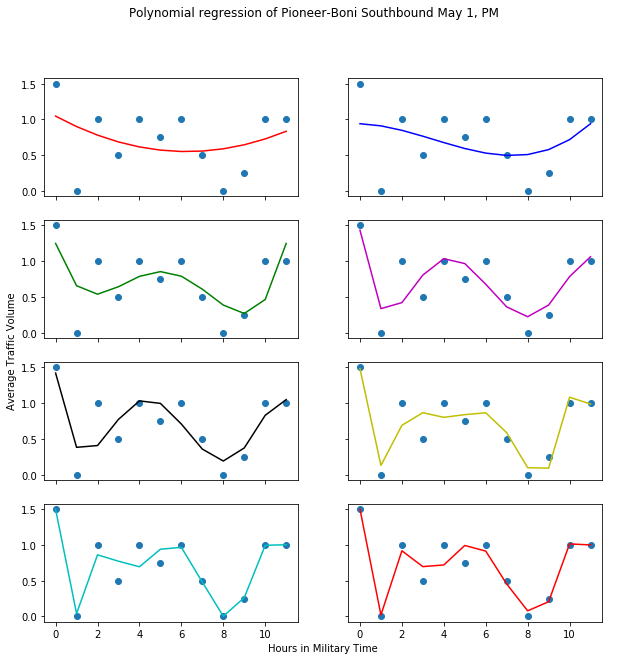

0.1372833501071476
0.903931772630216


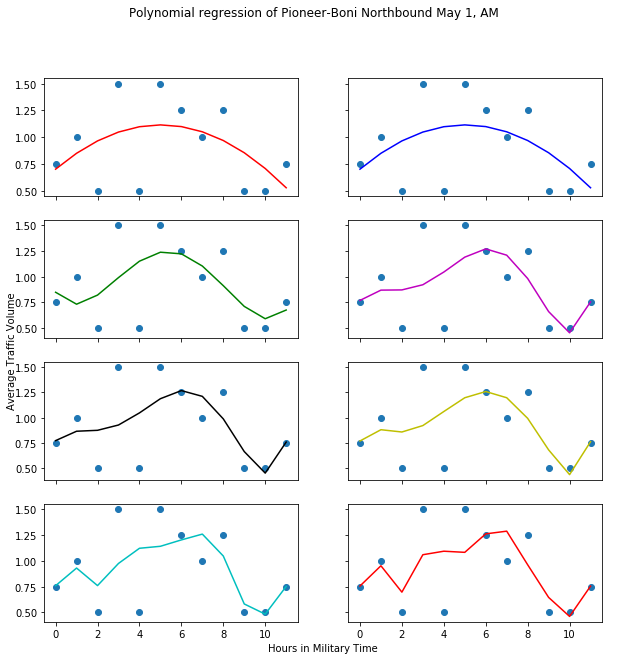

0.28602456982736596
0.41096760727650605


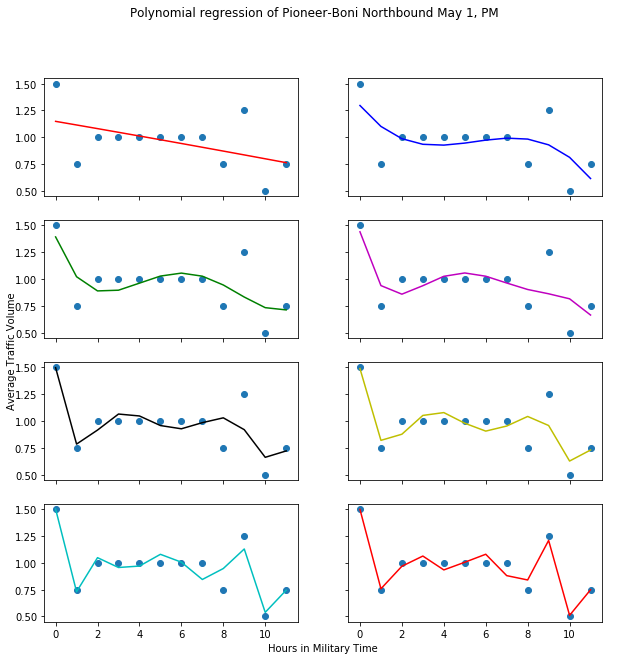

0.08699185237100346
0.8754592157066128


In [8]:
rms,r2, model = analyze(daylists_south[22][3][0:12], 12, "Pioneer-Boni Southbound May 1, AM")
print(rms)
print(r2)
rms,r2, model = analyze(daylists_south[22][3][12:24], 12, "Pioneer-Boni Southbound May 1, PM")
print(rms)
print(r2)
rms,r2, model = analyze(daylists_north[22][3][0:12], 12, "Pioneer-Boni Northbound May 1, AM")
print(rms)
print(r2)
rms,r2, model = analyze(daylists_north[22][3][12:24], 12, "Pioneer-Boni Northbound May 1, PM")
print(rms)
print(r2)

### I am still unconvinced
So let's take several other roads and see what results come out.

And wow there is an actual clear trend! 

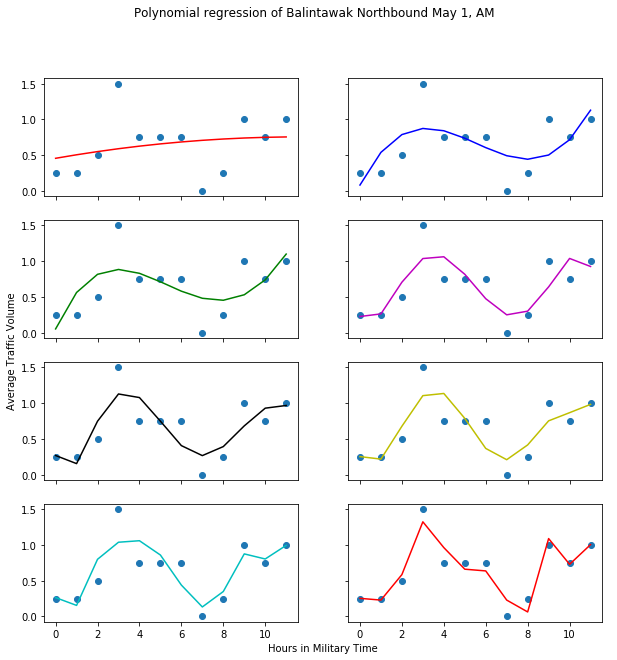

0.21653395276857249
0.7088206495297956


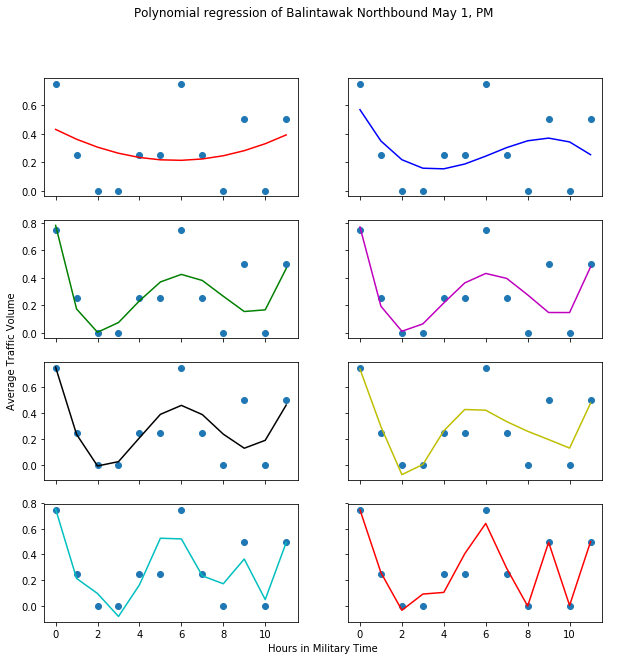

0.13050770655085953
0.7607174974088002


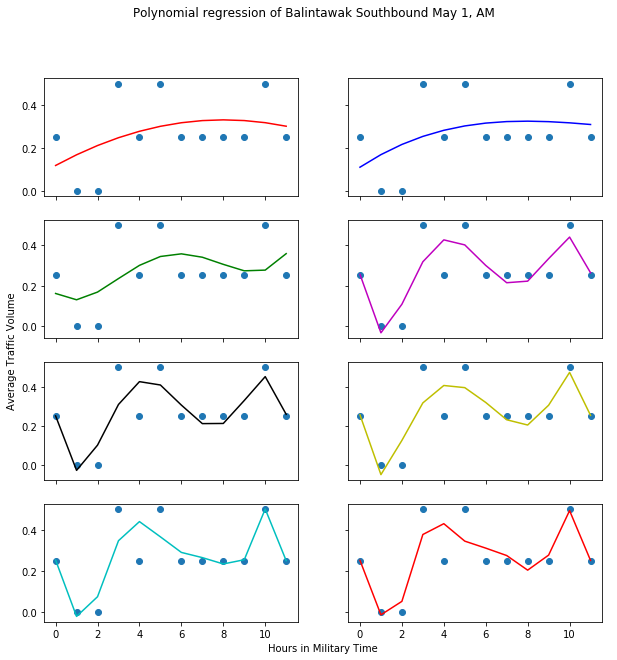

0.08445709082867445
0.721450297616546


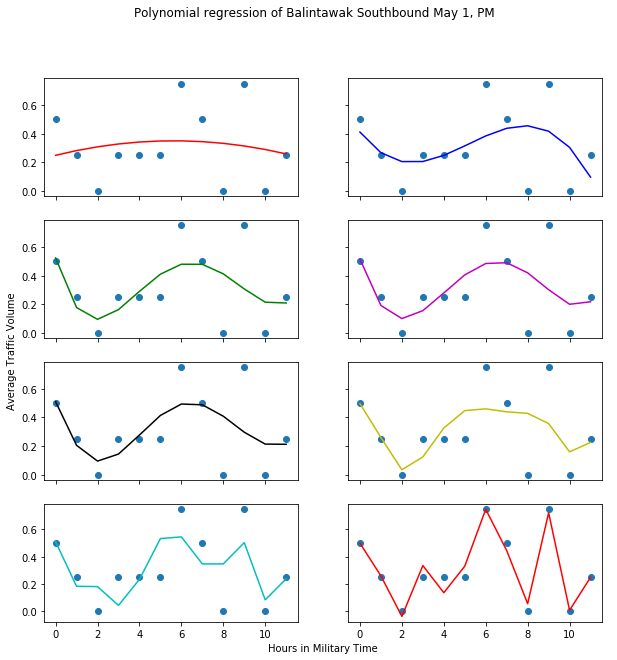

0.18582932723896978
0.4587553092635984


In [9]:
rms, r2, model = analyze(daylists_north[0][0][0:12], 12, "Balintawak Northbound May 1, AM")
print(rms)
print(r2)
rms,r2, model = analyze(daylists_north[0][0][12:24], 12, "Balintawak Northbound May 1, PM")
print(rms)
print(r2)
rms,r2, model = analyze(daylists_south[0][0][0:12], 12, "Balintawak Southbound May 1, AM")
print(rms)
print(r2)
rms,r2, model = analyze(daylists_south[0][0][12:24], 12, "Balintawak Southbound May 1, PM")
print(rms)
print(r2)

### Model validation:
Note that we need to test the model against unseen data. To validate, we average AM/PM model across 6 training days and test against AM/PM of 1 test day.

In [10]:
AM_training_south = np.zeros(12) 
PM_training_south = np.zeros(12) 

AM_training_north = np.zeros(12) 
PM_training_north = np.zeros(12) 

AM_test_south = np.zeros(12) 
PM_test_south = np.zeros(12) 

AM_test_north = np.zeros(12) 
PM_test_north = np.zeros(12) 

def process_data(data): 
    final_weighted_training = []
    final_weighted_test = []
    
    for k in range(0,24): # hour points
        for i in range(0,7): # days
            temp_training = []
            temp_test = []
            for j in range(0, numlines): # lines
                if(i != 6): # pick last day (monday) for testing and the rest for training
                    temp_training.append(data[j][i][k])
                    
                else:
                    temp_test.append(data[j][i][k])      
            if (i!=6):
                final_weighted_training.append(statistics.mean(temp_training))
            else:
                final_weighted_test.append(statistics.mean(temp_test))
    return final_weighted_training[0:12],final_weighted_training[12:24], final_weighted_test[0:12], final_weighted_test[12:24]       

# South data
AM_training_south, PM_training_south, AM_test_south, PM_test_south = process_data(daylists_south)
# North data
AM_training_north, PM_training_north, AM_test_north, PM_test_north = process_data(daylists_north)

print("Training set given by: ")
print(AM_training_north)
print(PM_training_north)
print(AM_training_south)
print(PM_training_south)
print("Testing set given by: ")
print(AM_test_north)
print(PM_test_north)
print(AM_test_south)
print(PM_test_south)

Training set given by: 
[0.49324324324324326, 0.34459459459459457, 0.7094594594594594, 0.7567567567567568, 0.75, 0.7702702702702703, 0.34459459459459457, 0.777027027027027, 1.0675675675675675, 0.8513513513513513, 0.581081081081081, 0.918918918918919]
[0.777027027027027, 0.3108108108108108, 0.5608108108108109, 0.4594594594594595, 0.7364864864864865, 0.6756756756756757, 0.8851351351351351, 0.7364864864864865, 0.18243243243243243, 0.5878378378378378, 0.4189189189189189, 0.8716216216216216]
[0.6283783783783784, 0.41216216216216217, 0.668918918918919, 0.47297297297297297, 0.6824324324324325, 0.5337837837837838, 0.42567567567567566, 0.7027027027027027, 0.7635135135135135, 0.3716216216216216, 0.4391891891891892, 0.7364864864864865]
[0.7027027027027027, 0.31756756756756754, 0.49324324324324326, 0.46621621621621623, 0.581081081081081, 0.6824324324324325, 0.6824324324324325, 1.135135135135135, 0.18243243243243243, 0.5067567567567568, 0.5067567567567568, 1.1554054054054055]
Testing set given by: 

Now, we run both training and test data.

Start with:
### AM Southbound

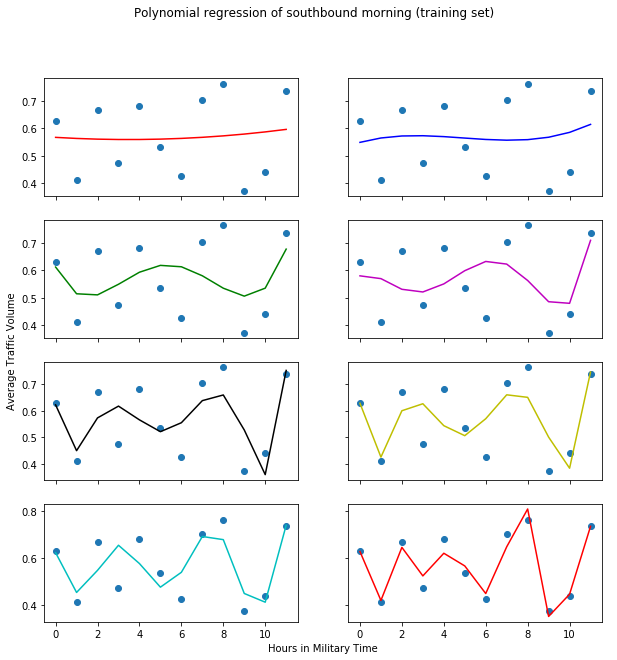

In [11]:
model_rms, model_r2, model = analyze(AM_training_south, 12, "southbound morning (training set)")

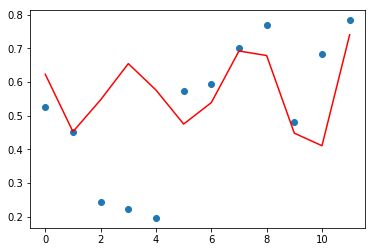

Test rms and r2:  0.2103275911920545 -0.11402195421509354
Training rms and r2:  0.08706690781540677 0.5893891150122086


In [12]:
x = range(0,12)
x = np.array(x)

plt.plot(x, AM_test_south, 'o')
plt.plot(x, model, 'r-')
plt.savefig("Validation_Southbound_Morning.png")
plt.show()

test_rms = (sqrt(mean_squared_error(AM_test_south, model)))
test_r2 = (r2_score(AM_test_south, model))

print("Test rms and r2: ", test_rms, test_r2)
print("Training rms and r2: ", model_rms, model_r2)

### PM Southbound

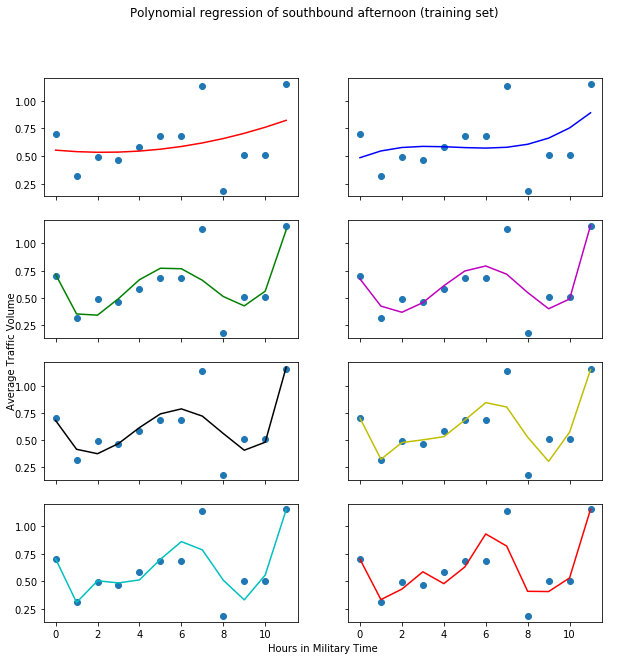

In [13]:
model_rms, model_r2, model = analyze(PM_training_south, 12, "southbound afternoon (training set)")

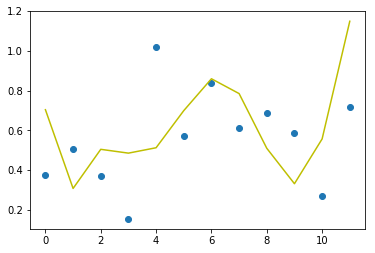

Test rms and r2:  0.28021190031264837 -0.4427546922742498
Training rms and r2:  0.15811036254908328 0.6726481013012273


In [14]:
x = range(0,12)
x = np.array(x)

plt.plot(x, PM_test_south, 'o')
plt.plot(x, model, 'y-')
plt.savefig("Validation_Southbound_Afternoon.png")
plt.show()

test_rms = (sqrt(mean_squared_error(PM_test_south, model)))
test_r2 = (r2_score(PM_test_south, model))

print("Test rms and r2: ", test_rms, test_r2)
print("Training rms and r2: ", model_rms, model_r2)

### AM Northbound

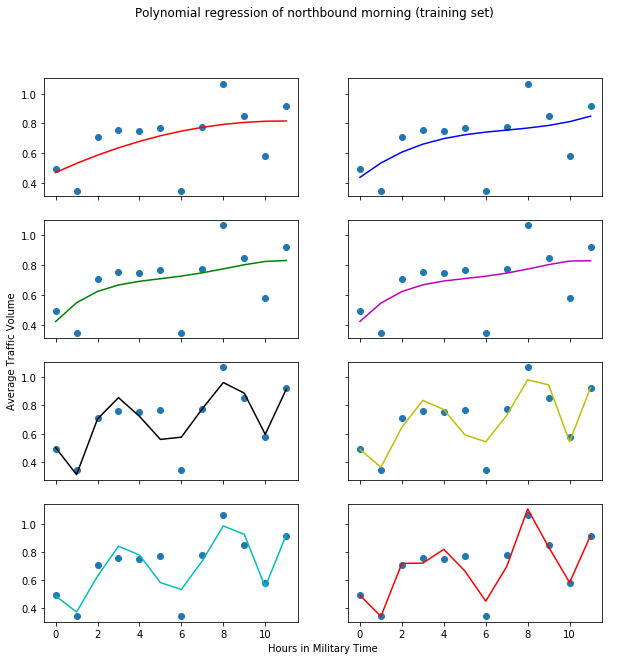

In [15]:
model_rms, model_r2, model = analyze(AM_training_north, 12, "northbound morning (training set)")

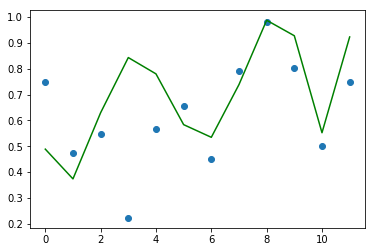

Test rms and r2:  0.2193508510200622 -0.2638136480068092
Training rms and r2:  0.09176950864666321 0.8100501749140133


In [16]:
x = range(0,12)
x = np.array(x)

plt.plot(x, AM_test_north, 'o')
plt.plot(x, model, 'g-')
plt.savefig("Validation_Northbound_Morning.png")
plt.show()

test_rms = (sqrt(mean_squared_error(AM_test_north, model)))
test_r2 = (r2_score(AM_test_north, model))

print("Test rms and r2: ", test_rms, test_r2)
print("Training rms and r2: ", model_rms, model_r2)

### PM Northbound

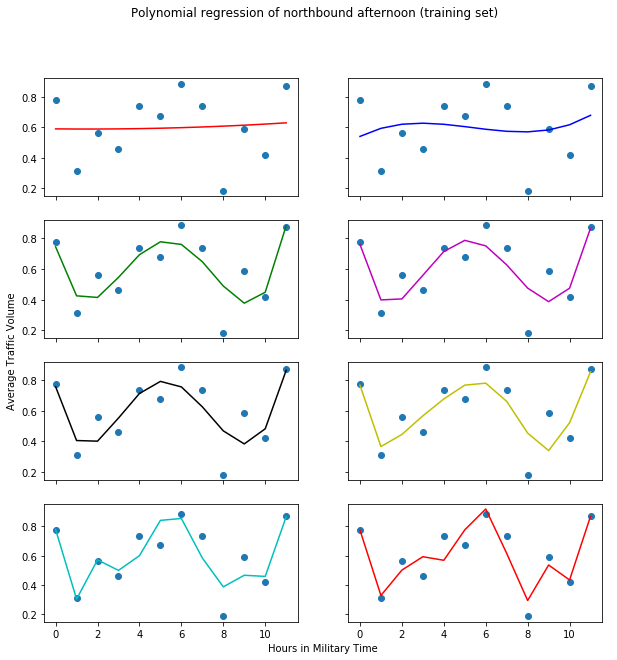

In [19]:
model_rms, model_r2, model = analyze(PM_training_north, 12, "northbound afternoon (training set)")

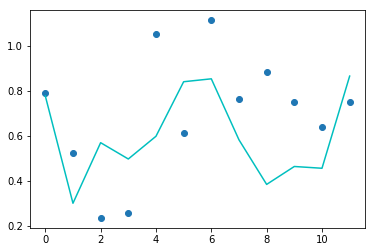

Test rms and r2:  0.28257050092881886 -0.19648162842227568
Training rms and r2:  0.10414966105028947 0.759673610031149


In [20]:
x = range(0,12)
x = np.array(x)

plt.plot(x, PM_test_north, 'o')
plt.plot(x, model, 'c-')
plt.savefig("Validation_Northbound_Afternoon.png")
plt.show()

test_rms = (sqrt(mean_squared_error(PM_test_north, model)))
test_r2 = (r2_score(PM_test_north, model))

print("Test rms and r2: ", test_rms, test_r2)
print("Training rms and r2: ", model_rms, model_r2)

### Summary of results:
Using polynomial regression of degree 8, a model was produced for the mornings and afternoons of both the southbound and northbound data. 

The RMS and R^2 results were used as measures to determine whether the model was a good fit for the test data. 

The following results were obtained:
1. #### Southbound AM ####

    Test RMS: 
    
    Training RMS: 
    
    Test $R^2$: 
    
    Training $R^2$: 
    
2. #### Southbound PM ####

    Test RMS:  
    
    Training RMS: 
    
    Test $R^2$: 
    
    Training $R^2$:   
    
3. #### Northbound AM ####

    Test RMS:  
    
    Training RMS: 
    
    Test $R^2$: 
    
    Test $R^2$: 
    
4. #### Northbound PM ####

    Test RMS:  
    
    Training RMS:  
    
    Test $R^2$: 
    
    Training $R^2$: 
    
As observable, the model is not a good fit for the test data. This could be due to a number of factors such as:
1. #### The fact that the day was not taken into account ####
       Note that the wednesday of this dataset was a holiday. 
2. #### The lack of data ####
        Perhaps a bigger dataset could account for more nuances. 
3. #### The method of validation ####
        Perhaps there is a better way to validate the data. In this case, the hour (0, 1,...,23) which directly corresponds to (12 AM, 1AM, ... , 11PM), was the independent feature. That is, the weights of the training and test data were processed in such a way that it was trying to describe the average traffic volume at that hour. It is possible that validation should have occurred with the day as a basis. For example, out of all the 4 mondays in the month of data extraction, test the corresponding value against 1 random monday in the year. Of course, this is a time consuming approach but it might yield different results.
4. #### Other external factors ####
        For example, there is a possibility that an accident had occurred on a certain day.

#### Plan of Action:

The plan of action moving forward is to find more data. This can be done either by extracting more data and/or finding sources of data. It seems that the main culprit for the less than savory model is the lack of data.